In [13]:
import pandas as pd


h_X = pd.read_csv('data_clean/train_h_X_v1.csv')
h_y = pd.read_csv("data_clean/train_h_y.csv").to_numpy().ravel() # flatten

no_ads_X = pd.read_csv('data_clean/train_no_ads_X_v1.csv')
no_ads_y = pd.read_csv('data_clean/train_no_ads_y.csv').to_numpy().ravel()

In [17]:
from sklearn.model_selection import train_test_split


h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(h_X, h_y, test_size=0.2, random_state=13)
no_ads_X_train, no_ads_X_test, no_ads_y_train, no_ads_y_test = train_test_split(no_ads_X, no_ads_y, test_size=0.4, random_state=13)

print("--- h datast target variable stats ---")
print(f"mean: {h_y.mean():.2f}")
print(f"std: {h_y.std():.2f}")
print(f"min: {h_y.min():.2f}")
print(f"max: {h_y.max():.2f}")
print(f"shape: {h_X.shape}")

print("\n--- no-ads datast target variable stats ---")
print(f"mean: {no_ads_y.mean():.2f}")
print(f"std: {no_ads_y.std():.2f}")
print(f"min: {no_ads_y.min():.2f}")
print(f"max: {no_ads_y.max():.2f}")
print(f"shape: {no_ads_X.shape}")

--- h datast target variable stats ---
mean: -484.89
std: 229.45
min: -1747.63
max: -59.02
shape: (1411, 100)

--- no-ads datast target variable stats ---
mean: -545.91
std: 245.22
min: -1915.78
max: -56.45
shape: (12774, 112)


In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

h_gbr = GradientBoostingRegressor(random_state = 1065)
no_ads_gbr = GradientBoostingRegressor(random_state = 1065)

param_grid_basic = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

param_grid_comprehensive = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'loss': ['squared_error', 'absolute_error', 'huber']
}

def rand_search_cv(X, y, model, param_grid):
    rand_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=1065,
    )

    rand_search.fit(X, y)
    return rand_search

h_cv = rand_search_cv(X=h_X_train, y=h_y_train, model=h_gbr, param_grid=param_grid_basic)
h_best_model = h_cv.best_estimator_

no_ads_cv = rand_search_cv(X=no_ads_X_train, y=no_ads_y_train, model=no_ads_gbr, param_grid=param_grid_basic)
no_ads_best_model = no_ads_cv.best_estimator_

print(f"--- h dataset ---")
print(f"best params: {h_cv.best_params_}")
print(f"best CV R^2: {h_cv.best_score_}")
print(f"best test R^2: {h_cv.score(h_X_test, h_y_test)}")

print(f"--- no-ads dataset ---")
print(f"best params: {no_ads_cv.best_params_}")
print(f"best CV R^2: {no_ads_cv.best_score_}")
print(f"best test R^2: {no_ads_cv.score(no_ads_X_test, no_ads_y_test)}")

--- h dataset ---
best params: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.1}
best CV R^2: 0.41085615106658036
best test R^2: 0.4673793843408045
--- no-ads dataset ---
best params: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
best CV R^2: 0.5168972318605936
best test R^2: 0.5130701567262876


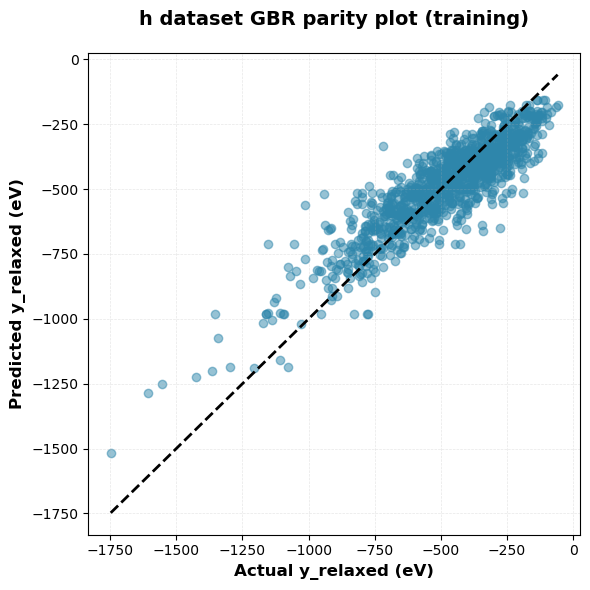

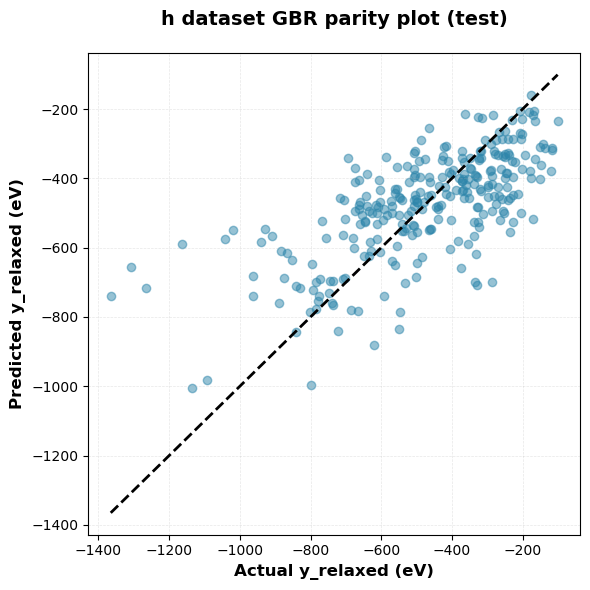

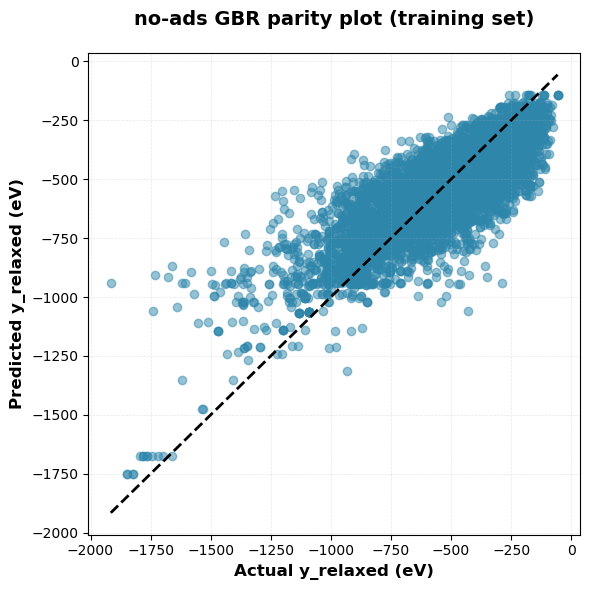

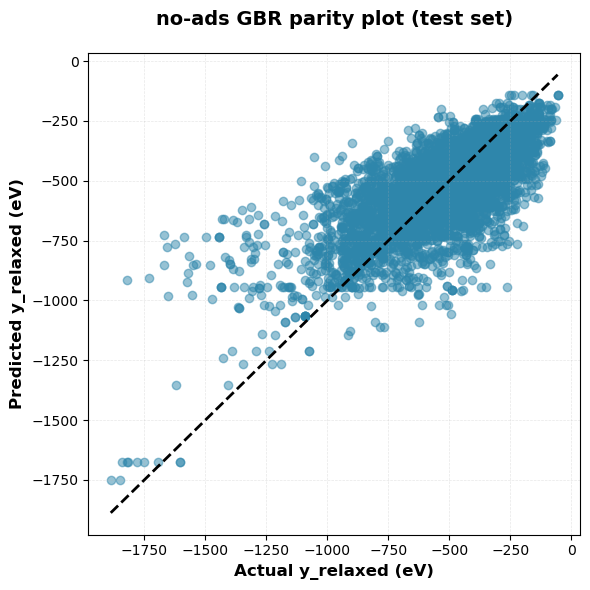

In [ ]:
import matplotlib.pyplot as plt


def parity_plot(X, y, model, title):
    plt.figure(figsize=(6,6), dpi=100)
    plt.scatter(y, model.predict(X), alpha=0.5, color='#2E86AB')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Actual y_relaxed (eV)', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted y_relaxed (eV)', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

parity_plot(h_X_train, h_y_train, h_best_model, "h dataset GBR parity plot (training)")
parity_plot(h_X_test, h_y_test, h_best_model, "h dataset GBR parity plot (test)")
parity_plot(no_ads_X_train, no_ads_y_train, no_ads_best_model, "no-ads GBR parity plot (training)")
parity_plot(no_ads_X_test, no_ads_y_test, no_ads_best_model, "no-ads GBR parity plot (test)")

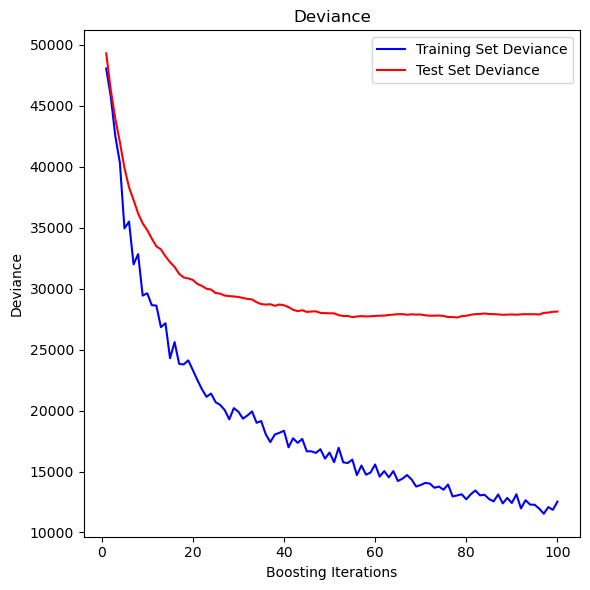

In [31]:
import numpy as np


h_test_score = np.zeros((h_cv.best_params_["n_estimators"],), dtype=np.float64)


for i, h_y_pred in enumerate(h_best_model.staged_predict(h_X_test)):
    h_test_score[i] = mean_squared_error(h_y_test, h_y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(h_cv.best_params_["n_estimators"]) + 1,
    h_best_model.train_score_,
    "b-",
    label="Training Set Deviance"
)

plt.plot(
    np.arange(h_cv.best_params_["n_estimators"]) + 1,
    h_test_score, "r-", label="Test Set Deviance"
)

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

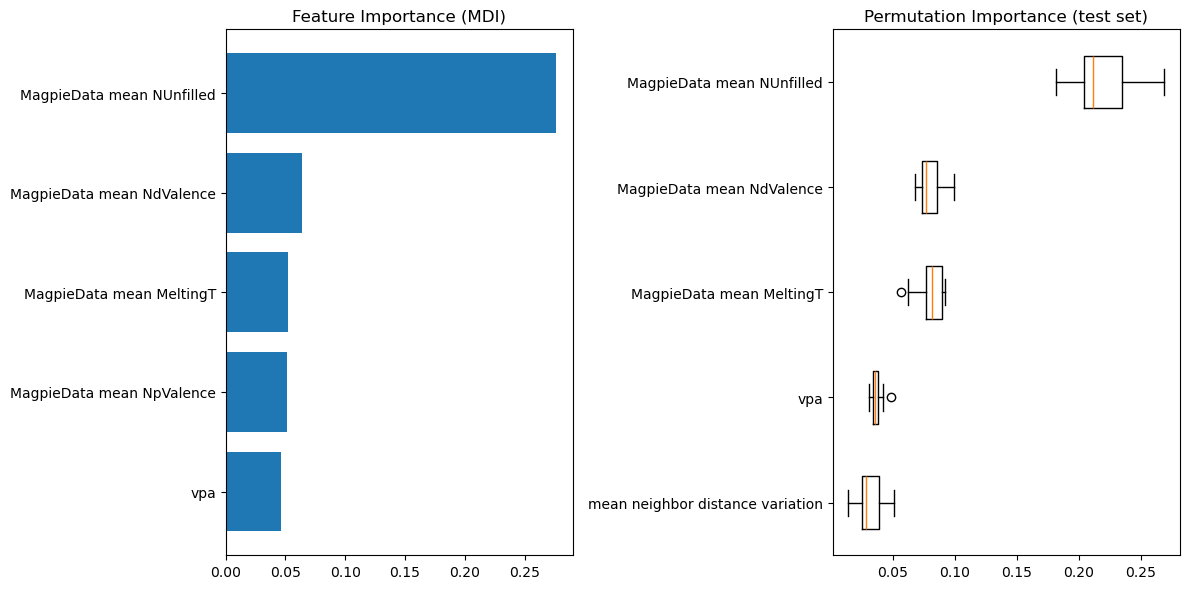

In [33]:
# Feature importance plots
feature_importance = h_best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
feature_names = h_X.columns.tolist()

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Show only top 20 features
top_n = 5
sorted_idx_top = sorted_idx[-top_n:]  # Get top 20
pos = np.arange(top_n) + 0.5
plt.barh(pos, feature_importance[sorted_idx_top], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx_top])
plt.title("Feature Importance (MDI)")

# Permutation importance
result = permutation_importance(
    h_best_model, h_X_test, h_y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_idx = result.importances_mean.argsort()
sorted_idx_top = sorted_idx[-top_n:]

plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx_top].T, 
    vert=False, 
    tick_labels=np.array(feature_names)[sorted_idx_top]
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
from scipy.stats import randint 

new_param_grid = {
    'n_estimators': randint(20, 150),  # Lower since optimal was ~20-30
    'learning_rate': [0.01, 0.05, 0.1, 0.15],  # Added 0.05 and 0.15
    'max_depth': [2, 3, 4],  # Shallower - removed 5, added 2
    'min_samples_split': [5, 10, 20, 30],  # Higher values to reduce overfitting
    'min_samples_leaf': [2, 4, 8, 12],  # Higher - removed 1, added 8 and 12
    'subsample': [0.6, 0.7, 0.8, 0.9],  # Lower values for regularization
    'max_features': ['sqrt', 'log2', None]  # Added to limit features per split
}

h_gbr = GradientBoostingRegressor(random_state=1065)
no_ads_gbr = GradientBoostingRegressor(random_state=1065)

h_rand_search = RandomizedSearchCV(
    estimator=h_gbr,
    param_distributions=new_param_grid,
    n_iter=50,  # Try 50-100 random combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=1065,
    return_train_score=True
)

no_ads_rand_search = RandomizedSearchCV(
    estimator=no_ads_gbr,
    param_distributions=new_param_grid,
    n_iter=50,  # Try 50-100 random combinations
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=1065,
    return_train_score=True
)

h_rand_search.fit(h_X_train, h_y_train)
no_ads_rand_search.fit(no_ads_X_train, no_ads_y_train)

print(f"--- h dataset ---")
print(f"best params: {h_rand_search.best_params_}")
print(f"best CV R^2: {h_rand_search.best_score_}")
print(f"best test R^2: {h_rand_search.score(h_X_test, h_y_test)}")

print(f"--- no-ads dataset ---")
print(f"best params: {no_ads_rand_search.best_params_}")
print(f"best CV R^2: {no_ads_rand_search.best_score_}")
print(f"best test R^2: {no_ads_rand_search.score(no_ads_X_test, no_ads_y_test)}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=20, n_estimators=60, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=20, n_estimators=60, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=20, n_estimators=60, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=20, n_estimators=60, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=20, n_estimators=60, subsample=0.7; total time=   0.0s
[CV] END learning_rate=0.15, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=30, n_estimators=63, subsample=0.9; total time=   0.0s
[CV] END learning_r